## Cone contact classification
This notebook contains the code to reproduce the classification of contacts between cones and bipolar cells, including the cross validation and the plots shown in figure 2

In [77]:
import numpy as np
from scipy.stats import itemfreq
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
import seaborn as sns
from sklearn import cross_validation
from sklearn import svm
from sklearn.decomposition import PCA
%matplotlib inline
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
matplotlib.rcParams.update({'mathtext.default': 'regular'})
matplotlib.rcParams.update({'font.size': 14})

In [2]:
sns.set_style("whitegrid")

In [3]:
BC_ids=np.loadtxt('data/BC_IDs_new').astype(int)

In [4]:
all_contacts=pd.read_pickle('data/cone_contact_data')

In [5]:
cut_off_cones=np.array([73,72,71,74,201,202,211,203,88,204,142,34,4,30,199])+2000
cones_outside_cbc9=np.array([193,209,200,198,197,199,73,72,71,74,69,67,66,211,86,88,87,120,85,204,84,207,128,114,126,127,125,142,130,104,106,175,135])+2000
BC_excluded=np.array([691,709,827,836])
blue_cones=np.array([2006,2007,2009,2024,2028,2029])

In [6]:
contact_summary=all_contacts[np.in1d(all_contacts['cone'],cut_off_cones,invert=True)\
                             &np.in1d(all_contacts['cell'],BC_excluded,invert=True)][['cell','cone','type']]\
                            .drop_duplicates().reset_index().drop('index',axis=1)

In [7]:
contact_summary.loc[(contact_summary['type']<63),'group']='off'
contact_summary.loc[(contact_summary['type']>62),'group']='on'
contact_summary.loc[(contact_summary['type']==71),'group']='rbc'

In [8]:
for i in range(contact_summary.shape[0]):
    contact_summary.loc[i,'area']=np.sum(all_contacts['area'][(all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['cone']==contact_summary['cone'][i])])

In [9]:
for i in range(contact_summary.shape[0]):
    contact_summary.loc[i,'excentricity']=np.min(all_contacts['excentricity'][(all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['cone']==contact_summary['cone'][i])])

In [10]:
for i in range(contact_summary.shape[0]):
    contact_summary.loc[i,'angle']=np.max(all_contacts['angle'][(all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['cone']==contact_summary['cone'][i])])

In [11]:
for i in range(contact_summary.shape[0]):
    contact_summary.loc[i,'branch_dist']=np.min(all_contacts['branch_dist'][(all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['cone']==contact_summary['cone'][i])])

In [12]:
for i in range(contact_summary.shape[0]):
    contact_summary.loc[i,'end_dist']=np.min(all_contacts['end_dist'][(all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['cone']==contact_summary['cone'][i])])

In [13]:
for i in range(contact_summary.shape[0]):
    if (contact_summary['group'][i]=='on'):
        contact_summary.loc[i,'height']=all_contacts['height'][(all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['cone']==contact_summary['cone'][i])\
                                                                   &(all_contacts['angle']==contact_summary['angle'][i])].values[0]
    else:
        contact_summary.loc[i,'height']=all_contacts['height'][(all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['cone']==contact_summary['cone'][i])\
                                                                   &(all_contacts['excentricity']==contact_summary['excentricity'][i])].values[0]

In [14]:
for i in range(contact_summary.shape[0]):
    contact_summary.loc[i,'count']=np.sum((all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['cone']==contact_summary['cone'][i]))

In [15]:
contact_summary=contact_summary[contact_summary['area']>0].reset_index().drop('index',axis=1)

In [16]:
contact_summary['area']/=1e6
contact_summary['branch_dist']/=1e3
contact_summary['branch_dist']=np.clip(contact_summary['branch_dist'],1e-2,1e2)
contact_summary['end_dist']/=1e3
contact_summary['end_dist']=np.clip(contact_summary['end_dist'],1e-2,1e2)
contact_summary['excentricity']/=1e3

In [17]:
contact_summary_log_norm=contact_summary.copy()
contact_summary_log_norm['excentricity']=np.log(contact_summary_log_norm['excentricity'])
contact_summary_log_norm['area']=np.log(contact_summary_log_norm['area'])
contact_summary_log_norm['branch_dist']=np.log(contact_summary_log_norm['branch_dist'])
for i in range(4,contact_summary.shape[1]):
    contact_summary_log_norm.ix[:,i]-=np.mean(contact_summary_log_norm.ix[:,i])
    contact_summary_log_norm.ix[:,i]/=np.std(contact_summary_log_norm.ix[:,i])

In [18]:
classified_contacts=np.loadtxt('data/cone_training_data.csv',delimiter=',',usecols=range(4))
classified_contacts=pd.DataFrame(classified_contacts,columns=['cell','cone','type','class'])
classified_contacts=classified_contacts[np.in1d(classified_contacts['cone'],cut_off_cones,invert=True)\
                                        &np.in1d(classified_contacts['cell'],BC_excluded,invert=True)].reset_index().drop('index',axis=1)

In [19]:
rows_to_del=[]
for i in range(classified_contacts.shape[0]):
    if np.sum((contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['cone']==classified_contacts['cone'][i]))==0:
        rows_to_del+=[i]
classified_contacts=classified_contacts.drop(classified_contacts.index[rows_to_del]).reset_index().drop('index',axis=1)

In [20]:
# classified_contacts.loc[:,'type']=''
classified_contacts.loc[:,'group']=''
classified_contacts.loc[:,'area']=0
classified_contacts.loc[:,'excentricity']=0
classified_contacts.loc[:,'angle']=0
classified_contacts.loc[:,'branch_dist']=0
classified_contacts.loc[:,'end_dist']=0
classified_contacts.loc[:,'height']=0
classified_contacts.loc[:,'count']=0
cc_log_norm=classified_contacts.copy()

In [21]:
for i in range(classified_contacts.shape[0]):
    classified_contacts.loc[i,'group']=contact_summary['group'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['cone']==classified_contacts['cone'][i])].values[0]
    classified_contacts.loc[i,'area']=contact_summary['area'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['cone']==classified_contacts['cone'][i])].values[0]
    classified_contacts.loc[i,'excentricity']=contact_summary['excentricity'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['cone']==classified_contacts['cone'][i])].values[0]
    classified_contacts.loc[i,'angle']=contact_summary['angle'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['cone']==classified_contacts['cone'][i])].values[0]
    classified_contacts.loc[i,'branch_dist']=contact_summary['branch_dist'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['cone']==classified_contacts['cone'][i])].values[0]
    classified_contacts.loc[i,'end_dist']=contact_summary['end_dist'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['cone']==classified_contacts['cone'][i])].values[0]
    classified_contacts.loc[i,'height']=contact_summary['height'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['cone']==classified_contacts['cone'][i])].values[0]
    classified_contacts.loc[i,'count']=contact_summary['count'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['cone']==classified_contacts['cone'][i])].values[0]
for i in range(cc_log_norm.shape[0]):
    cc_log_norm.loc[i,'group']=contact_summary_log_norm['group'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['cone']==cc_log_norm['cone'][i])].values[0]
    cc_log_norm.loc[i,'area']=contact_summary_log_norm['area'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['cone']==cc_log_norm['cone'][i])].values[0]
    cc_log_norm.loc[i,'excentricity']=contact_summary_log_norm['excentricity'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['cone']==cc_log_norm['cone'][i])].values[0]
    cc_log_norm.loc[i,'angle']=contact_summary_log_norm['angle'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['cone']==cc_log_norm['cone'][i])].values[0]
    cc_log_norm.loc[i,'branch_dist']=contact_summary_log_norm['branch_dist'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['cone']==cc_log_norm['cone'][i])].values[0]
    cc_log_norm.loc[i,'end_dist']=contact_summary_log_norm['end_dist'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['cone']==cc_log_norm['cone'][i])].values[0]
    cc_log_norm.loc[i,'height']=contact_summary_log_norm['height'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['cone']==cc_log_norm['cone'][i])].values[0]
    cc_log_norm.loc[i,'count']=contact_summary_log_norm['count'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['cone']==cc_log_norm['cone'][i])].values[0]

In [22]:
cc_plots=classified_contacts.copy()
for i in range(cc_plots.shape[0]):
    cc_plots.loc[i,'min_height']=np.min(all_contacts['height'][(all_contacts['cell']==cc_plots['cell'][i])&(all_contacts['cone']==cc_plots['cone'][i])])
for i in range(cc_plots.shape[0]):
    cc_plots.loc[i,'mean_height']=np.mean(all_contacts['height'][(all_contacts['cell']==cc_plots['cell'][i])&(all_contacts['cone']==cc_plots['cone'][i])])
for i in range(cc_plots.shape[0]):
    cc_plots.loc[i,'excent_min_height']=all_contacts['excentricity'][(all_contacts['cell']==cc_plots['cell'][i])&(all_contacts['cone']==cc_plots['cone'][i])\
                                                                   &(all_contacts['height']==cc_plots['min_height'][i])].values[0]
for i in range(cc_plots.shape[0]):
    cc_plots.loc[i,'area_log']=np.log10(cc_plots.ix[i,'area'])
for i in range(cc_plots.shape[0]):
    cc_plots.loc[i,'end_dist_log']=np.log10(cc_plots.ix[i,'end_dist'])
for i in range(cc_plots.shape[0]):
    cc_plots.loc[i,'branch_dist_log']=np.log10(cc_plots.ix[i,'branch_dist'])
cc_plots['excent_min_height']/=1e3

### Figures for poster/paper

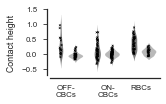

In [23]:
plt.figure(figsize=(5/2.54,3/2.54))
sns.set(context="paper",style='white',font='Arial',rc={"xtick.major.size": 0, "ytick.major.size": 4,"lines.markeredgewidth": 0.02,"lines.markersize":10})
ax = sns.violinplot(x="group",y="min_height", data=cc_plots,hue='class',hue_order=[0,1],order=['off','on','rbc'],orient="v",inner=None,\
                    linewidth=0,palette=sns.light_palette('gray',n_colors=3,reverse=True))
ax2=sns.stripplot(x="group", y="min_height", data=cc_plots, hue='class',hue_order=[0,1],order=['off','on','rbc'],jitter=0.05,split=True, marker='x',size=2,linewidth=0.5,palette=['black','black'])
ax.set(xlabel='',xticklabels=['OFF-\nCBCs','ON-\nCBCs','RBCs'],xticks=[-0.05,1.1,2],ylim=(-0.7,1.5))
plt.legend([])
ax.set_ylabel('Contact height')
sns.despine(offset=3)
# plt.savefig('figures/cc_stats_min_height.svg',bbox_inches='tight',dpi=300)
plt.show()

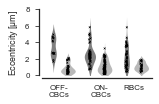

In [24]:
plt.figure(figsize=(5/2.54,3/2.54))
sns.set(context="paper",style='white',font='Arial',rc={"xtick.major.size": 0, "ytick.major.size": 4,"lines.markeredgewidth": 0.02,"lines.markersize":10})
ax = sns.violinplot(x="group",y="excentricity", data=cc_plots,hue='class',hue_order=[0,1],order=['off','on','rbc'],orient="v",inner=None,\
                    linewidth=0,palette=sns.light_palette('gray',n_colors=3,reverse=True))
ax = sns.stripplot(x="group", y="excentricity", data=cc_plots, hue='class',hue_order=[0,1],order=['off','on','rbc'],jitter=0.05,split=True,\
                   size=2,marker='x',linewidth=0.5,palette=['black','black'])
ax.set(xlabel='',xticklabels=['OFF-\nCBCs','ON-\nCBCs','RBCs'],xticks=[-0.05,1.1,2],ylim=(0,8),yticks=[0,2,4,6,8])
plt.legend([])
ax.set_ylabel('Eccentricity [$\mu m$]')
sns.despine(offset=3)
# plt.savefig('figures/cc_stats_eccentricity_min.svg',bbox_inches='tight',dpi=300)
plt.show()

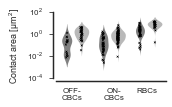

In [25]:
plt.figure(figsize=(5/2.54,3/2.54))
sns.set(context="paper",style='white',font='Arial',rc={"xtick.major.size": 0, "ytick.major.size": 4,"lines.markeredgewidth": 0.02,"lines.markersize":10})
ax = sns.stripplot(x="group", y="area", data=cc_plots, hue='class',hue_order=[0,1],order=['off','on','rbc'],jitter=0, size=0,marker='x',palette=['black','black'])
plt.legend([],loc='upper left')
ax2 = ax.twinx()
sns.violinplot(x="group",y="area_log", data=cc_plots,hue='class',hue_order=[0,1],order=['off','on','rbc'],orient="v",inner=None,linewidth=0,palette=sns.light_palette('gray',n_colors=3,reverse=True),ax=ax2)
sns.stripplot(x="group", y="area_log", data=cc_plots, hue='class',hue_order=[0,1],order=['off','on','rbc'],jitter=0.05,split=True,size=2,marker='x',linewidth=0.5,palette=['black','black',],ax=ax2)
ax.set(yscale='log',ylim=(1e-4,1e2),xlabel='',xticklabels=['OFF-\nCBCs','ON-\nCBCs','RBCs'],xticks=[-0.05,1.1,2],ylabel='Contact area [$\mu m^2$]')
ax.set_yticks([1e-4,1e-2,1,1e2])
ax2.set(ylim=(-4,2),ylabel='',yticks=[])
sns.despine(offset=3)
plt.legend([])
# plt.savefig('figures/cc_stats_area.svg',bbox_inches='tight',dpi=300)
plt.show()

### Crossvalidation

In [26]:
#OFF-CBCs
for gamma in np.logspace(-4,-1,4):
    for C in np.logspace(0,6,7):
        loo=cross_validation.LeaveOneOut(cc_log_norm.ix[cc_log_norm['group']=='off',:].shape[0])
        clf_svm=svm.SVC(gamma=gamma,C=C)
        scores_svm_loo = cross_validation.cross_val_score(clf_svm,cc_log_norm.ix[cc_log_norm['group']=='off',5:].as_matrix(),\
                                                          cc_log_norm.ix[cc_log_norm['group']=='off']['class'].as_matrix(),cv=loo)
        prediction_svm_loo = cross_validation.cross_val_predict(clf_svm,cc_log_norm.ix[cc_log_norm['group']=='off',5:].as_matrix(),\
                                                                cc_log_norm.ix[cc_log_norm['group']=='off']['class'].as_matrix(),cv=loo)
        print(gamma,C,np.mean(scores_svm_loo),\
              np.sum(prediction_svm_loo>cc_log_norm.ix[cc_log_norm['group']=='off']['class'].as_matrix())/np.sum(cc_log_norm.ix[cc_log_norm['group']=='off']['class'].as_matrix()==0)\
              ,np.sum(prediction_svm_loo<cc_log_norm.ix[cc_log_norm['group']=='off']['class'].as_matrix())/np.sum(cc_log_norm.ix[cc_log_norm['group']=='off']['class'].as_matrix()==1))

0.0001 1.0 0.68 1.0 0.0
0.0001 10.0 0.68 1.0 0.0
0.0001 100.0 0.88 0.3125 0.0294117647059
0.0001 1000.0 0.92 0.125 0.0588235294118
0.0001 10000.0 0.9 0.1875 0.0588235294118
0.0001 100000.0 0.9 0.125 0.0882352941176
0.0001 1000000.0 0.9 0.125 0.0882352941176
0.001 1.0 0.68 1.0 0.0
0.001 10.0 0.88 0.3125 0.0294117647059
0.001 100.0 0.92 0.125 0.0588235294118
0.001 1000.0 0.9 0.1875 0.0588235294118
0.001 10000.0 0.9 0.125 0.0882352941176
0.001 100000.0 0.9 0.125 0.0882352941176
0.001 1000000.0 0.9 0.125 0.0882352941176
0.01 1.0 0.88 0.3125 0.0294117647059
0.01 10.0 0.92 0.125 0.0588235294118
0.01 100.0 0.9 0.1875 0.0588235294118
0.01 1000.0 0.86 0.25 0.0882352941176
0.01 10000.0 0.86 0.25 0.0882352941176
0.01 100000.0 0.86 0.25 0.0882352941176
0.01 1000000.0 0.86 0.25 0.0882352941176
0.1 1.0 0.9 0.1875 0.0588235294118
0.1 10.0 0.84 0.375 0.0588235294118
0.1 100.0 0.84 0.3125 0.0882352941176
0.1 1000.0 0.84 0.3125 0.0882352941176
0.1 10000.0 0.84 0.3125 0.0882352941176
0.1 100000.0 0.84 0.

In [27]:
#ON-CBCs
print('gamma','C','score','false positive','false negative')
for gamma in np.logspace(-4,-1,4):
    for C in np.logspace(-1,3,5):
        for false_weight in range(2,7):
            loo=cross_validation.LeaveOneOut(cc_log_norm.ix[cc_log_norm['group']=='on',:].shape[0])
            clf_svm=svm.SVC(gamma=gamma,C=C,class_weight={0:false_weight/2,1:1})
            scores_svm_loo = cross_validation.cross_val_score(clf_svm,cc_log_norm.ix[cc_log_norm['group']=='on',5:].as_matrix(),\
                                                              cc_log_norm.ix[cc_log_norm['group']=='on']['class'].as_matrix(),cv=loo)
            prediction_svm_loo = cross_validation.cross_val_predict(clf_svm,cc_log_norm.ix[cc_log_norm['group']=='on',5:].as_matrix(),\
                                                                    cc_log_norm.ix[cc_log_norm['group']=='on']['class'].as_matrix(),cv=loo)
            print(gamma,C,false_weight/2,np.mean(scores_svm_loo),\
                  np.sum(prediction_svm_loo>cc_log_norm.ix[cc_log_norm['group']=='on']['class'].as_matrix())/np.sum(cc_log_norm.ix[cc_log_norm['group']=='on']['class'].as_matrix()==0),\
                  np.sum(prediction_svm_loo<cc_log_norm.ix[cc_log_norm['group']=='on']['class'].as_matrix())/np.sum(cc_log_norm.ix[cc_log_norm['group']=='on']['class'].as_matrix()==1))

gamma C score false positive false negative
0.0001 0.1 1.0 0.601851851852 1.0 0.0
0.0001 0.1 1.5 0.0 1.0 1.0
0.0001 0.1 2.0 0.398148148148 0.0 1.0
0.0001 0.1 2.5 0.398148148148 0.0 1.0
0.0001 0.1 3.0 0.398148148148 0.0 1.0
0.0001 1.0 1.0 0.601851851852 1.0 0.0
0.0001 1.0 1.5 0.0 1.0 1.0
0.0001 1.0 2.0 0.398148148148 0.0 1.0
0.0001 1.0 2.5 0.398148148148 0.0 1.0
0.0001 1.0 3.0 0.398148148148 0.0 1.0
0.0001 10.0 1.0 0.712962962963 0.720930232558 0.0
0.0001 10.0 1.5 0.740740740741 0.651162790698 0.0
0.0001 10.0 2.0 0.601851851852 0.093023255814 0.6
0.0001 10.0 2.5 0.435185185185 0.0 0.938461538462
0.0001 10.0 3.0 0.398148148148 0.0 1.0
0.0001 100.0 1.0 0.842592592593 0.325581395349 0.0461538461538
0.0001 100.0 1.5 0.861111111111 0.209302325581 0.0923076923077
0.0001 100.0 2.0 0.851851851852 0.139534883721 0.153846153846
0.0001 100.0 2.5 0.851851851852 0.116279069767 0.169230769231
0.0001 100.0 3.0 0.759259259259 0.116279069767 0.323076923077
0.0001 1000.0 1.0 0.851851851852 0.255813953488

In [28]:
#RBCs
for gamma in np.logspace(-4,0,5):
    for C in np.logspace(0,5,6):
        loo=cross_validation.LeaveOneOut(cc_log_norm.ix[cc_log_norm['group']=='rbc',:].shape[0])
        clf_svm=svm.SVC(gamma=gamma,C=C)
        scores_svm_loo = cross_validation.cross_val_score(clf_svm,cc_log_norm.ix[cc_log_norm['group']=='rbc',5:].as_matrix(),\
                                                          cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix(),cv=loo)
        prediction_svm_loo = cross_validation.cross_val_predict(clf_svm,cc_log_norm.ix[cc_log_norm['group']=='rbc',5:].as_matrix(),\
                                                                cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix(),cv=loo)
        print(gamma,C,np.mean(scores_svm_loo),\
              np.sum(prediction_svm_loo>cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix())/np.sum(cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix()==0),\
              np.sum(prediction_svm_loo<cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix())/np.sum(cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix()==1))

0.0001 1.0 0.641791044776 0.0 1.0
0.0001 10.0 0.641791044776 0.0 1.0
0.0001 100.0 0.805970149254 0.0697674418605 0.416666666667
0.0001 1000.0 0.805970149254 0.093023255814 0.375
0.0001 10000.0 0.805970149254 0.139534883721 0.291666666667
0.0001 100000.0 0.820895522388 0.116279069767 0.291666666667
0.001 1.0 0.641791044776 0.0 1.0
0.001 10.0 0.805970149254 0.0697674418605 0.416666666667
0.001 100.0 0.805970149254 0.093023255814 0.375
0.001 1000.0 0.820895522388 0.116279069767 0.291666666667
0.001 10000.0 0.805970149254 0.162790697674 0.25
0.001 100000.0 0.850746268657 0.116279069767 0.208333333333
0.01 1.0 0.791044776119 0.0697674418605 0.458333333333
0.01 10.0 0.805970149254 0.116279069767 0.333333333333
0.01 100.0 0.791044776119 0.162790697674 0.291666666667
0.01 1000.0 0.820895522388 0.139534883721 0.25
0.01 10000.0 0.89552238806 0.093023255814 0.125
0.01 100000.0 0.89552238806 0.093023255814 0.125
0.1 1.0 0.805970149254 0.116279069767 0.333333333333
0.1 10.0 0.791044776119 0.1395348

### Classification figures

In [29]:
off_svm_cv=svm.SVC(gamma=1e-3,C=100)
on_svm_cv=svm.SVC(gamma=1e-2,C=1000,class_weight={0:2,1:1})
rbc_svm_cv=svm.SVC(gamma=1e-2,C=10000)
loo=cross_validation.LeaveOneOut(cc_log_norm.ix[cc_log_norm['group']=='off',:].shape[0])
off_scores_svm_cv = cross_validation.cross_val_score(off_svm_cv,cc_log_norm.ix[cc_log_norm['group']=='off',5:].as_matrix(),\
                                                        cc_log_norm.ix[cc_log_norm['group']=='off']['class'].as_matrix(),cv=loo)
off_prediction_cv = cross_validation.cross_val_predict(off_svm_cv,cc_log_norm.ix[cc_log_norm['group']=='off',5:].as_matrix(),\
                                                        cc_log_norm.ix[cc_log_norm['group']=='off']['class'].as_matrix(),cv=loo)
loo=cross_validation.LeaveOneOut(cc_log_norm.ix[cc_log_norm['group']=='on',:].shape[0])
on_scores_svm_cv = cross_validation.cross_val_score(on_svm_cv,cc_log_norm.ix[cc_log_norm['group']=='on',5:].as_matrix(),\
                                                        cc_log_norm.ix[cc_log_norm['group']=='on']['class'].as_matrix(),cv=loo)
on_prediction_cv = cross_validation.cross_val_predict(on_svm_cv,cc_log_norm.ix[cc_log_norm['group']=='on',5:].as_matrix(),\
                                                        cc_log_norm.ix[cc_log_norm['group']=='on']['class'].as_matrix(),cv=loo)
loo=cross_validation.LeaveOneOut(cc_log_norm.ix[cc_log_norm['group']=='rbc',:].shape[0])
rbc_scores_svm_cv = cross_validation.cross_val_score(rbc_svm_cv,cc_log_norm.ix[cc_log_norm['group']=='rbc',5:].as_matrix(),\
                                                        cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix(),cv=loo)
rbc_prediction_cv = cross_validation.cross_val_predict(rbc_svm_cv,cc_log_norm.ix[cc_log_norm['group']=='rbc',5:].as_matrix(),\
                                                        cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix(),cv=loo)

In [30]:
cc_cv_plot=classified_contacts.copy()
cc_cv_plot.loc[:,'prediction']=0
cc_cv_plot.loc[cc_cv_plot['group']=='off','prediction']=off_prediction_cv
cc_cv_plot.loc[cc_cv_plot['group']=='on','prediction']=on_prediction_cv
cc_cv_plot.loc[cc_cv_plot['group']=='rbc','prediction']=rbc_prediction_cv
cc_cv_plot.loc[:,'error']=np.abs(cc_cv_plot['class']-cc_cv_plot['prediction'])

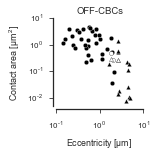

In [31]:
plt.figure(figsize=(4/2.54,4/2.54))
sns.set(font='Arial',style='white',context='paper',rc={"xtick.major.size": 4, "ytick.major.size": 4})
ax=plt.scatter(cc_cv_plot[(cc_cv_plot['group']=='off')&(cc_cv_plot['class']==1)&(cc_cv_plot['prediction']==1)]['excentricity'],\
               cc_cv_plot[(cc_cv_plot['group']=='off')&(cc_cv_plot['class']==1)&(cc_cv_plot['prediction']==1)]['area'],marker='o',c='k',s=20,lw=0.3,edgecolor='w').axes
plt.scatter(cc_cv_plot[(cc_cv_plot['group']=='off')&(cc_cv_plot['class']==0)&(cc_cv_plot['prediction']==0)]['excentricity'],\
               cc_cv_plot[(cc_cv_plot['group']=='off')&(cc_cv_plot['class']==0)&(cc_cv_plot['prediction']==0)]['area'],marker='^',c='k',s=20,lw=0.3,edgecolor='w')
plt.scatter(cc_cv_plot[(cc_cv_plot['group']=='off')&(cc_cv_plot['class']==1)&(cc_cv_plot['prediction']==0)]['excentricity'],\
               cc_cv_plot[(cc_cv_plot['group']=='off')&(cc_cv_plot['class']==1)&(cc_cv_plot['prediction']==0)]['area'],marker='o',c='w',s=17,lw=0.3)
plt.scatter(cc_cv_plot[(cc_cv_plot['group']=='off')&(cc_cv_plot['class']==0)&(cc_cv_plot['prediction']==1)]['excentricity'],\
               cc_cv_plot[(cc_cv_plot['group']=='off')&(cc_cv_plot['class']==0)&(cc_cv_plot['prediction']==1)]['area'],marker='^',c='w',s=17,lw=0.3)
ax.set(xscale='log',xlim=(1e-1,1e1),yscale='log',ylim=(5e-3,1e1))
plt.title('OFF-CBCs')
ax.set_xlabel('Eccentricity [$\mu m$]')
ax.set_ylabel('Contact area [$\mu m^2$]')
sns.despine(offset=3)
# plt.savefig('figures/classification_off.svg',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

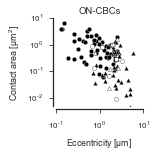

In [32]:
plt.figure(figsize=(4/2.54,4/2.54))
sns.set(font='Arial',style='white',context='paper',rc={"xtick.major.size": 4, "ytick.major.size": 4})
ax=plt.scatter(cc_cv_plot[(cc_cv_plot['group']=='on')&(cc_cv_plot['class']==1)&(cc_cv_plot['prediction']==1)]['excentricity'],\
               cc_cv_plot[(cc_cv_plot['group']=='on')&(cc_cv_plot['class']==1)&(cc_cv_plot['prediction']==1)]['area'],marker='o',c='k',s=20,lw=0.3,edgecolor='w').axes
plt.scatter(cc_cv_plot[(cc_cv_plot['group']=='on')&(cc_cv_plot['class']==0)&(cc_cv_plot['prediction']==0)]['excentricity'],\
               cc_cv_plot[(cc_cv_plot['group']=='on')&(cc_cv_plot['class']==0)&(cc_cv_plot['prediction']==0)]['area'],marker='^',c='k',s=20,lw=0.3,edgecolor='w')
plt.scatter(cc_cv_plot[(cc_cv_plot['group']=='on')&(cc_cv_plot['class']==1)&(cc_cv_plot['prediction']==0)]['excentricity'],\
               cc_cv_plot[(cc_cv_plot['group']=='on')&(cc_cv_plot['class']==1)&(cc_cv_plot['prediction']==0)]['area'],marker='o',c='w',s=17,lw=0.3)
plt.scatter(cc_cv_plot[(cc_cv_plot['group']=='on')&(cc_cv_plot['class']==0)&(cc_cv_plot['prediction']==1)]['excentricity'],\
               cc_cv_plot[(cc_cv_plot['group']=='on')&(cc_cv_plot['class']==0)&(cc_cv_plot['prediction']==1)]['area'],marker='^',c='w',s=17,lw=0.3)
ax.set(xscale='log',xlim=(1e-1,1e1),yscale='log',ylim=(5e-3,1e1))
plt.title('ON-CBCs')
ax.set_xlabel('Eccentricity [$\mu m$]')
ax.set_ylabel('Contact area [$\mu m^2$]')
sns.despine(offset=3)
# plt.savefig('figures/classification_on.svg',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

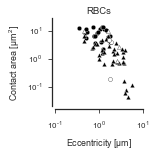

In [33]:
plt.figure(figsize=(4/2.54,4/2.54))
sns.set(font='Arial',style='white',context='paper',rc={"xtick.major.size": 4, "ytick.major.size": 4})
ax=plt.scatter(cc_cv_plot[(cc_cv_plot['group']=='rbc')&(cc_cv_plot['class']==1)&(cc_cv_plot['prediction']==1)]['excentricity'],\
               cc_cv_plot[(cc_cv_plot['group']=='rbc')&(cc_cv_plot['class']==1)&(cc_cv_plot['prediction']==1)]['area'],marker='o',c='k',s=20,lw=0.3,edgecolor='w').axes
plt.scatter(cc_cv_plot[(cc_cv_plot['group']=='rbc')&(cc_cv_plot['class']==0)&(cc_cv_plot['prediction']==0)]['excentricity'],\
               cc_cv_plot[(cc_cv_plot['group']=='rbc')&(cc_cv_plot['class']==0)&(cc_cv_plot['prediction']==0)]['area'],marker='^',c='k',s=20,lw=0.3,edgecolor='w')
plt.scatter(cc_cv_plot[(cc_cv_plot['group']=='rbc')&(cc_cv_plot['class']==1)&(cc_cv_plot['prediction']==0)]['excentricity'],\
               cc_cv_plot[(cc_cv_plot['group']=='rbc')&(cc_cv_plot['class']==1)&(cc_cv_plot['prediction']==0)]['area'],marker='o',c='w',s=17,lw=0.3)
plt.scatter(cc_cv_plot[(cc_cv_plot['group']=='rbc')&(cc_cv_plot['class']==0)&(cc_cv_plot['prediction']==1)]['excentricity'],\
               cc_cv_plot[(cc_cv_plot['group']=='rbc')&(cc_cv_plot['class']==0)&(cc_cv_plot['prediction']==1)]['area'],marker='^',c='w',s=17,lw=0.3)
ax.set(xscale='log',xlim=(1e-1,1e1),yscale='log',ylim=(2e-2,3e1))
plt.title('RBCs')
ax.set_xlabel('Eccentricity [$\mu m$]')
ax.set_ylabel('Contact area [$\mu m^2$]')
sns.despine(offset=3)
# plt.savefig('figures/classification_rbc.svg',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

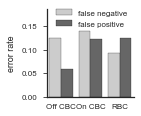

In [34]:
plt.figure(figsize=(4/2.54,4/2.54))
sns.set(font='Arial',context='paper',style='white',rc={"xtick.major.size": 0, "ytick.major.size": 4})
ax=sns.barplot(x='group',y='error',hue='class',data=cc_cv_plot,ci=None,palette=[np.array([0.8,0.8,0.8,1.]),np.array([0.4,0.4,0.4,1.])])
ax.set(ylabel='error rate',xlabel='',xticklabels=['Off CBC','On CBC','RBC'],ylim=(0,0.185),yticks=[0,0.05,0.1,0.15])
plt.legend(bbox_to_anchor=(1, 1.08),labels=['false negative','false positive'])
sns.despine()
# plt.savefig('figures/classication_performance.svg',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

### Classification

In [35]:
clf_svm_off=svm.SVC(gamma=1e-3,C=100)
clf_svm_on=svm.SVC(gamma=1e-2,C=1000,class_weight={0:2,1:1})
clf_svm_rbc=svm.SVC(gamma=1e-2,C=10000)
clf_svm_off.fit(cc_log_norm.ix[cc_log_norm['group']=='off',5:].as_matrix(),cc_log_norm.ix[cc_log_norm['group']=='off']['class'].as_matrix())
clf_svm_on.fit(cc_log_norm.ix[cc_log_norm['group']=='on',5:].as_matrix(),cc_log_norm.ix[cc_log_norm['group']=='on']['class'].as_matrix())
clf_svm_rbc.fit(cc_log_norm.ix[cc_log_norm['group']=='rbc',5:].as_matrix(),cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix())

SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [36]:
contact_summary.loc[:,'prediction']=0
contact_summary.ix[contact_summary['group']=='off','prediction']=clf_svm_off.predict(contact_summary_log_norm.ix[contact_summary_log_norm['group']=='off',4:11])
contact_summary.ix[contact_summary['group']=='on','prediction']=clf_svm_on.predict(contact_summary_log_norm.ix[contact_summary_log_norm['group']=='on',4:11])
contact_summary.ix[contact_summary['group']=='rbc','prediction']=clf_svm_rbc.predict(contact_summary_log_norm.ix[contact_summary_log_norm['group']=='rbc',4:11])

In [37]:
blue_cones=np.array([2006,2007,2009,2024,2028,2029])

In [38]:
all_cones=np.unique(contact_summary['cone'].as_matrix())
green_cones=all_cones[(np.in1d(all_cones,blue_cones,invert=True))&(np.in1d(all_cones,cones_outside_cbc9,invert=True))]

In [39]:
for i in range(contact_summary.shape[0]):
    if contact_summary.ix[i,'cone'] in blue_cones:
        contact_summary.loc[i,'cone_type']='blue'
    elif contact_summary.ix[i,'cone'] in green_cones:
        contact_summary.loc[i,'cone_type']='green'
    else:
        contact_summary.loc[i,'cone_type']='outside'

In [ ]:
# contact_summary.to_pickle('data/cone_contact_predictions')